In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club-loan-data-most-accurate/lending_club_info.csv
/kaggle/input/lending-club-loan-data-most-accurate/lending_club_loan_two.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, PrecisionRecallDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [4]:
def treat_outlier(df,feature):
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    IQR = Q3-Q1
    upper = Q3+(1.5*IQR)
    lower = Q1-(1.5*IQR)
    print(feature,upper,lower)
    df = df[(df[feature]>lower) & (df[feature]<upper)]
    return df

In [5]:
def box_hist_plot(df,feature):
    sns.set(style="darkgrid")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=df,x=feature,ax=ax_box)
    sns.histplot(data=df, x=feature, ax=ax_hist,kde=True)
    ax_box.set(xlabel='')
    plt.show()

In [6]:
def empLen(x):
    if(x=='10+ years'):
        return 10
    elif(x=='< 1 year'):
        return 0
    else:
        val = x.split()[0]
        return int(val)

# Problem Statement
Determining if a credit line should be extended to a business. If so, what should the repayment terms be in business recommendations?

# Understanding the Data
# Understanding the Data
<ul>
    <li><b>loan_amnt</b> : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.</li>
    <li><b>term</b> : The number of payments on the loan. Values are in months and can be either 36 or 60.</li>
    <li><b>int_rate</b> : Interest Rate on the loan</li>
    <li><b>installment</b> : The monthly payment owed by the borrower if the loan originates.</li>
    <li><b>grade</b> : JaiKisan assigned loan grade</li>
    <li><b>sub_grade</b> : JaiKisan assigned loan subgrade</li>
    <li><b>emp_title</b> :The job title supplied by the Borrower when applying for the loan.*</li>
    <li><b>emp_length</b> : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</li>
    <li><b>home_ownership</b> : The home ownership status provided by the borrower during registration or obtained from the credit report.</li>
    <li><b>annual_inc</b> : The self-reported annual income provided by the borrower during registration.</li>
    <li><b>verification_status</b> : Indicates if income was verified by JaiKisan, not verified, or if the income source was verified</li>
    <li><b>issue_d</b> : The month which the loan was funded</li>
    <li><b>loan_status</b> : Current status of the loan - Target Variable</li>
    <li><b>purpose</b> : A category provided by the borrower for the loan request.</li>
    <li><b>title</b> : The loan title provided by the borrower</li>
    <li><b>dti</b> : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested JaiKisan loan, divided by the borrower’s self-reported monthly income.</li>
    <li><b>earliest_cr_line</b> :The month the borrower's earliest reported credit line was opened</li>
    <li><b>open_acc</b> : The number of open credit lines in the borrower's credit file.</li>
    <li><b>pub_rec</b> : Number of derogatory public records</li>
    <li><b>revol_bal</b> : Total credit revolving balance</li>
    <li><b>revol_util</b> : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.</li>
    <li><b>total_acc</b> : The total number of credit lines currently in the borrower's credit file</li>
    <li><b>initial_list_status</b> : The initial listing status of the loan. Possible values are – W, F</li>
    <li><b>application_type</b> : Indicates whether the loan is an individual application or a joint application with two co-borrowers</li>
    <li><b>mort_acc</b> : Number of mortgage accounts.</li>
    <li><b>pub_rec_bankruptcies</b> : Number of public record bankruptcies</li>
    <li><b>Address</b> : Address of the borrower</li>
</ul>

In [7]:
data = pd.read_csv('../input/lending-club-loan-data-most-accurate/lending_club_loan_two.csv')

In [8]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [9]:
data.shape

(396030, 27)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

### From the above data we can say - 
- All columns are equally float and object
- Few columns have less non-null values, indicating some missing values

In [11]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,NaN,NaN,NaN,14113.888089,8357.441341,500.0,8000.0,12000.0,20000.0,40000.0
term,396030,2,36 months,302005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,396030.0,NaN,NaN,NaN,13.6394,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,NaN,NaN,NaN,431.849698,250.72779,16.08,250.33,375.43,567.3,1533.81
grade,396030,7,B,116018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,396030,35,B3,26655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,373103,173105,Teacher,4389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,377729,11,10+ years,126041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,396030,6,MORTGAGE,198348,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,396030.0,NaN,NaN,NaN,74203.175798,61637.621158,0.0,45000.0,64000.0,90000.0,8706582.0


### From the above table we can say - 
- Few columns despite being numerical are categorical in nature
- Address has 393700 unique values which is almost unique for all records

In [12]:
data.isnull().sum()/data.shape[0]*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

## Treating missing values - 
- Dropping null values from 'title','revol_util'and 'pub_rec_bankruptcies' as they are less than 1% of the record
- Imputing values in 'emp_title','emp_length' and 'mort_acc' as they have more missing records

In [13]:
data = data.dropna(subset=['title','revol_util','pub_rec_bankruptcies'])

In [14]:
data.isnull().sum()/data.shape[0]*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.761122
emp_length              4.594055
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.000000
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.000000
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.453192
pub_rec_bankruptcies    0.000000
address                 0.000000
dtype: float64

<b>Removed null values for 'title','revol_util'and 'pub_rec_bankruptcies'</b>

In [15]:
si_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cols_mode = ['emp_title','emp_length']
data[cols_mode] = si_mode.fit_transform(data[cols_mode])

In [16]:
si_median = SimpleImputer(missing_values=np.nan, strategy='median')
cols_median = ['mort_acc']
data[cols_median] = si_median.fit_transform(data[cols_median])

<b>Imputed values for 'emp_title','emp_length' and 'mort_acc'</b>

In [17]:
data.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
title                   0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64

## Checking for duplicates

In [18]:
data[data.duplicated()]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address


<b>No duplicated records.</b>
<hr>
<h1>Non-Graphincal Analysis</h1>

In [19]:
data['term'].value_counts()

 36 months    300024
 60 months     93441
Name: term, dtype: int64

<b>Most of the customer opt for 36months term</b>

In [20]:
(data['int_rate'].value_counts()).head(10)

10.99    12393
12.99     9560
15.61     9343
11.99     8488
8.90      8017
12.12     7354
7.90      7329
16.29     6577
13.11     6576
6.03      6289
Name: int_rate, dtype: int64

<b>Top interest rate is 10.99, 12.99 and 15.61.</b>

In [21]:
data['grade'].value_counts(normalize=True)*100

B    29.327894
C    26.750283
A    16.229906
D    16.022772
E     7.941494
F     2.960111
G     0.767540
Name: grade, dtype: float64

<b>Top Loan Grades are A,B,C and D</b>

In [22]:
(data['sub_grade'].value_counts(normalize=True)*100).head(10)

B3    6.739608
B4    6.473511
C1    5.974356
C2    5.702921
B2    5.688181
B5    5.579658
C3    5.356258
C4    5.111763
B1    4.846937
A5    4.688346
Name: sub_grade, dtype: float64

<b>Top Loan Sub Grades are from B and C.</b>

In [23]:
data.groupby(['grade','sub_grade'])['loan_status'].count()

grade  sub_grade
A      A1            9683
       A2            9504
       A3           10509
       A4           15716
       A5           18447
B      B1           19071
       B2           22381
       B3           26518
       B4           25471
       B5           21954
C      C1           23507
       C2           22439
       C3           21075
       C4           20113
       C5           18119
D      D1           15861
       D2           13841
       D3           12139
       D4           11580
       D5            9623
E      E1            7860
       E2            7371
       E3            6147
       E4            5334
       E5            4535
F      F1            3512
       F2            2727
       F3            2258
       F4            1766
       F5            1384
G      G1            1050
       G2             747
       G3             546
       G4             366
       G5             311
Name: loan_status, dtype: int64

In [24]:
data['emp_length'].value_counts(normalize=True)*100

10+ years    36.431703
2 years       9.047056
< 1 year      8.002999
3 years       7.997916
5 years       6.697673
1 year        6.515700
4 years       6.051618
6 years       5.273658
7 years       5.267813
8 years       4.846937
9 years       3.866926
Name: emp_length, dtype: float64

<b>Most loans are either taken by people with 10+ employment or 0-3 years of employment</b>

In [25]:
data['purpose'].value_counts(normalize=True)*100

debt_consolidation    59.244914
credit_card           20.987127
home_improvement       6.057972
other                  5.331097
major_purchase         2.214428
small_business         1.430114
car                    1.183333
medical                1.055240
moving                 0.720522
vacation               0.617844
house                  0.556593
wedding                0.455949
renewable_energy       0.082854
educational            0.062013
Name: purpose, dtype: float64

<b>Most of the loan purpose is 'debt_consolidation' or 'credit_card'</b>

In [26]:
data['home_ownership'].value_counts(normalize=True)*100

MORTGAGE    50.095942
RENT        40.351747
OWN          9.516221
OTHER        0.027957
NONE         0.007370
ANY          0.000762
Name: home_ownership, dtype: float64

<b>Most of the customers have either 'Mortgage' or 'Rented' home.</b>

In [27]:
data['initial_list_status'].value_counts(normalize=True)*100

f    60.220604
w    39.779396
Name: initial_list_status, dtype: float64

In [28]:
data['application_type'].value_counts(normalize=True)*100

INDIVIDUAL    99.842171
JOINT          0.090478
DIRECT_PAY     0.067350
Name: application_type, dtype: float64

<b>Almost all the application type is 'INDIVIDUAL'</b>

In [29]:
(data['emp_title'].value_counts(normalize=True)*100)[:10]

Teacher             6.871259
Manager             1.075572
Registered Nurse    0.467894
RN                  0.467640
Supervisor          0.460778
Sales               0.411727
Project Manager     0.379703
Owner               0.351238
Driver              0.335227
Office Manager      0.308287
Name: emp_title, dtype: float64

<b>Out of all the different emp title most common is 'Teacher' and 'Manager'</b>

In [30]:
data['loan_status'].value_counts(normalize=True)*100

Fully Paid     80.380974
Charged Off    19.619026
Name: loan_status, dtype: float64

<b>80% of the loans are fully paid</b>
<hr>
<h1>Feature Engineering</h1>
<h2>Creating date fields<h2>  

In [31]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [32]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

In [33]:
data['issue_month'] = data['issue_d'].dt.month
data['issue_year'] = data['issue_d'].dt.year
data.drop(columns=['issue_d'],inplace=True)

In [34]:
data['earliest_cr_line_month'] = data['earliest_cr_line'].dt.month
data['earliest_cr_line_year'] = data['earliest_cr_line'].dt.year
data.drop(columns=['earliest_cr_line'],inplace=True)

In [35]:
def getPinCode(x):
    arr = x.split(' ')
    pin = int(arr[-1])
    return pin

In [36]:
data['address'] = data['address'].apply(getPinCode)

## Encoding Target Variable

In [37]:
def targetVariable(x):
    if(x=='Fully Paid'):
        return 1
    return 0

In [38]:
data['loan_status'] = data['loan_status'].apply(targetVariable)

In [39]:
data.drop(columns=['title'],inplace=True)

## Creating flags for 'pub_rec', 'mort_acc' and 'pub_rec_bankruptcies'

In [40]:
def flagCreation(x):
    if(x>=1):
        return 1
    return 0

In [41]:
data['pub_rec'] = data['pub_rec'].apply(flagCreation)
data['mort_acc'] = data['mort_acc'].apply(flagCreation)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(flagCreation)

In [42]:
def categorize_purpose(x):
    if(x=='debt_consolidation' or x=='credit_card'):
        return x
    return 'other'

In [43]:
def categorize_home_ownership(x):
    if(x=='MORTGAGE' or x=='RENT'):
        return x
    return 'OTHER'

In [44]:
data['purpose'] = data['purpose'].apply(categorize_purpose)
data['home_ownership'] = data['home_ownership'].apply(categorize_home_ownership)

<hr>
<h1>Univariate Analysis</h1>

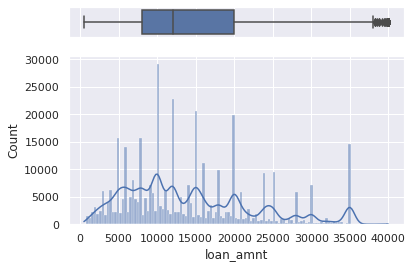

In [45]:
box_hist_plot(data,'loan_amnt')

## Treating Outliers

In [46]:
data = treat_outlier(data,'loan_amnt')

loan_amnt 38000.0 -10000.0


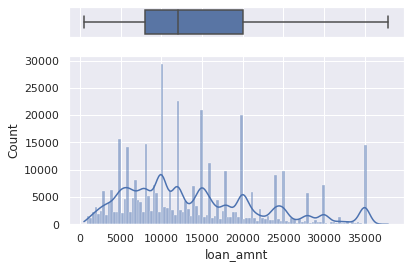

In [47]:
box_hist_plot(data,'loan_amnt')

### From the above graph we can say that - 
- Avg loan amount taken is around 13000
- 75% of the loan taken is under 20000
- 25% of the loan taken is under 9000

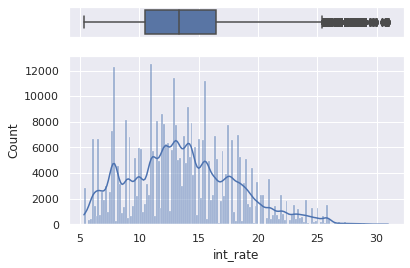

In [48]:
box_hist_plot(data,'int_rate')

## Treating Outliers

In [49]:
data = treat_outlier(data,'int_rate')

int_rate 25.489999999999995 1.4900000000000038


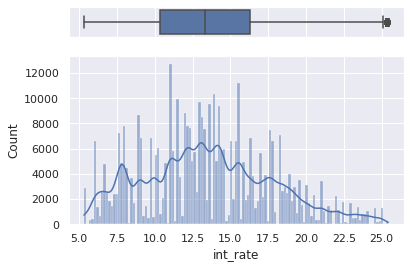

In [50]:
box_hist_plot(data,'int_rate')

### From the above graph we can say that - 
- Avg interest rate is around 13.5
- 75% of the interest rate is under 16
- 25% of the interest rate is under 11

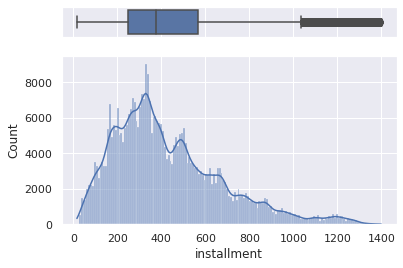

In [51]:
box_hist_plot(data,'installment')

In [52]:
data = treat_outlier(data,'installment')

installment 1037.06 -222.93999999999988


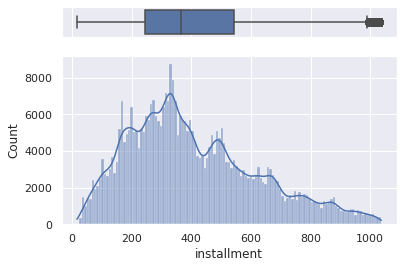

In [53]:
box_hist_plot(data,'installment')

### From the above graph we can say that - 
- Avg installment is around 385
- 75% of the installment is under 500
- 25% of the installment is under 250

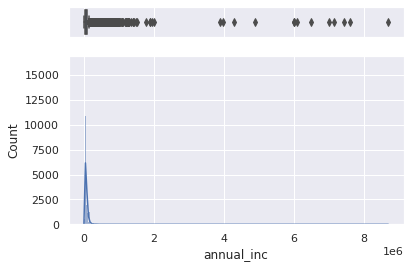

In [54]:
box_hist_plot(data,'annual_inc')

In [55]:
data['annual_inc'] = data['annual_inc'].apply(np.log)
data = treat_outlier(data,'annual_inc')

annual_inc 12.362531840963115 9.725549325426066


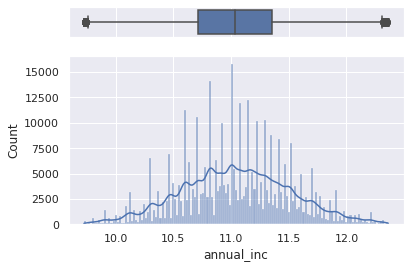

In [56]:
box_hist_plot(data,'annual_inc')

### From the above graph we can say that - 
- Avg annual income is around 59800
- 75% of the annual income is under 98700
- 25% of the annual income is under 49000

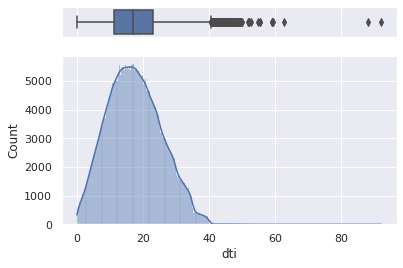

In [57]:
box_hist_plot(data,'dti')

In [58]:
data = treat_outlier(data,'dti')

dti 40.52 -6.120000000000003


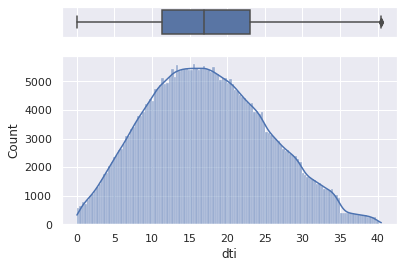

In [59]:
box_hist_plot(data,'dti')

### From the above graph we can say that - 
- Avg dti is around 17
- 75% of the dti is under 24
- 25% of the dti is under 13

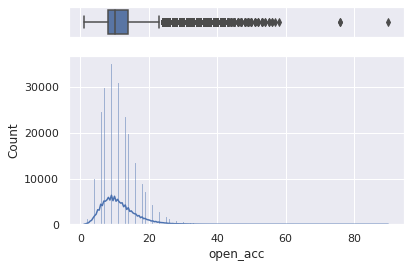

In [60]:
box_hist_plot(data,'open_acc')

## Treating Outliers

In [61]:
data = treat_outlier(data,'open_acc')

open_acc 23.0 -1.0


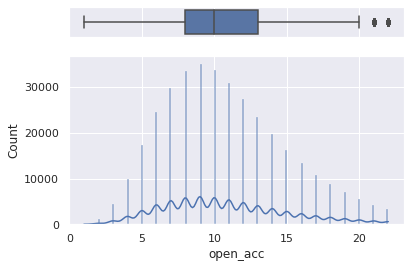

In [62]:
box_hist_plot(data,'open_acc')

### From the above graph we can say that - 
- Avg open account is around 10
- 75% of the open accoutn is under 12
- 25% of the open account is under 8

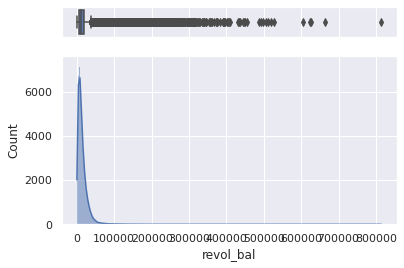

In [63]:
box_hist_plot(data,'revol_bal')

In [64]:
data['revol_bal'] = data['revol_bal'].apply(np.sqrt)
data = treat_outlier(data,'revol_bal')

revol_bal 225.662237120679 -12.46776893872989


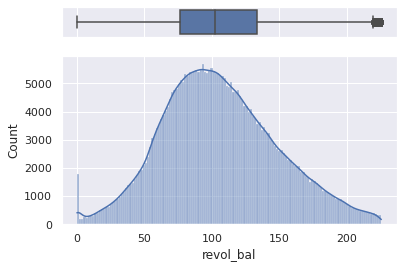

In [65]:
box_hist_plot(data,'revol_bal')

### From the above graph we can say that - 
- Avg revol_bal is around 11025
- 75% of the revol_bal is under 16900
- 25% of the revol_bal is under 5600

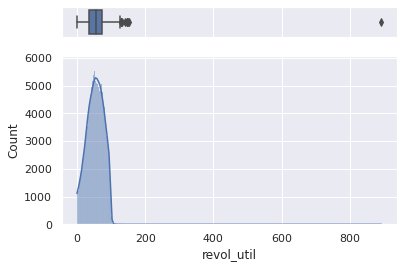

In [66]:
box_hist_plot(data,'revol_util')

## Treating Outliers

In [67]:
data = treat_outlier(data,'revol_util')

revol_util 127.75 -19.050000000000004


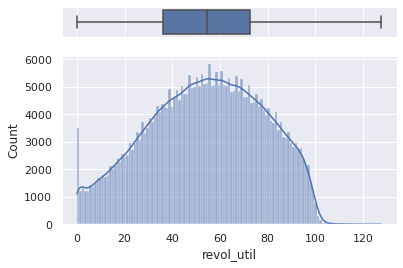

In [68]:
box_hist_plot(data,'revol_util')

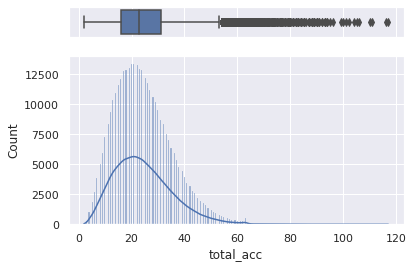

In [69]:
box_hist_plot(data,'total_acc')

In [70]:
data = treat_outlier(data,'total_acc')

total_acc 53.5 -6.5


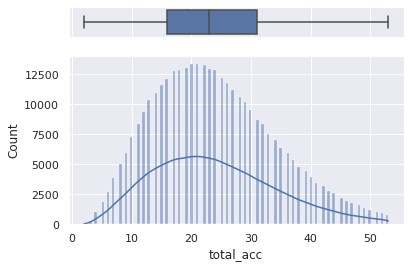

In [71]:
box_hist_plot(data,'total_acc')

### From the above graph we can say that - 
- Avg total account is around 25
- 75% of the total account is under 30
- 25% of the total acoount is under 18

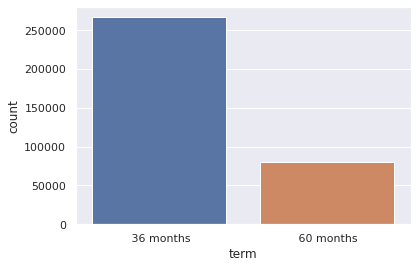

In [72]:
sns.countplot(data=data,x='term')
plt.show()

<b>As seen earlier 36 months have more number of loans</b>

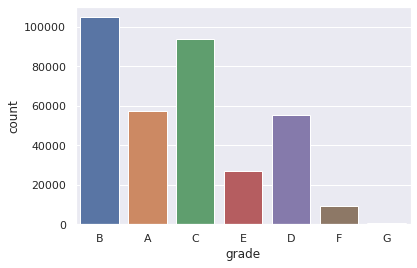

In [73]:
sns.countplot(x='grade',data=data)
plt.show()

<b>Grade A,B,C,D is having monst records</b>

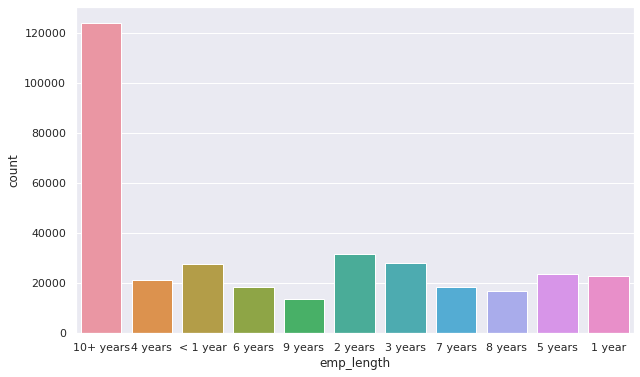

In [74]:
plt.figure(figsize=(10,6))
sns.countplot(x='emp_length',data=data)
plt.show()

<b>Most of the loans taken is eather 10+ or 0-3 years.</b>

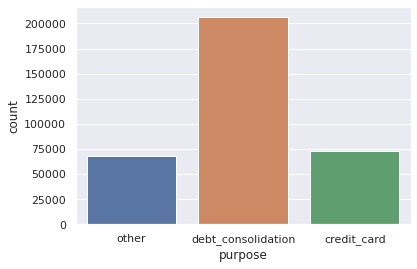

In [75]:
sns.countplot(x='purpose',data=data)
plt.show()

<b>Most loans are taken under Debt_consolidation purpose</b>

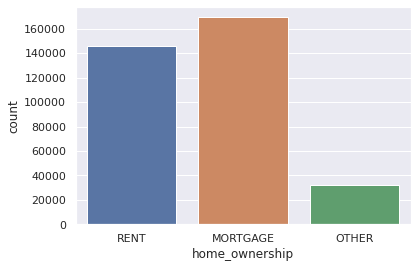

In [76]:
sns.countplot(x='home_ownership',data=data)
plt.show()

<b>Most of the Home_ownership is Rent and Mortgage</b>

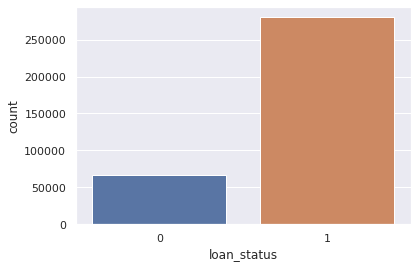

In [77]:
sns.countplot(x='loan_status',data=data)
plt.show()

<b>Most of the loans are "Paid Fully".</b>

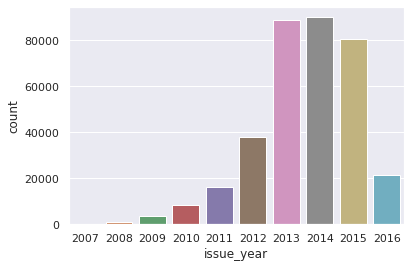

In [78]:
sns.countplot(x='issue_year',data=data)
plt.show()

<b>We can clearly see a increasing trend in loans taken over the past years</b>

<hr>

# Bivariate Analysis

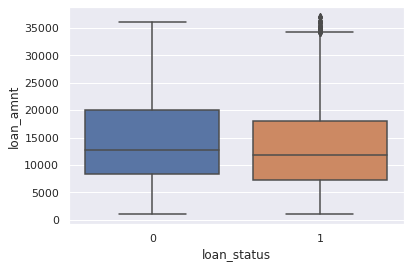

In [79]:
sns.boxplot(x='loan_status',y='loan_amnt',data=data)
plt.show()

<b>Average loans amount taken is higher in "Charged off" than in "Paid fully".</b>

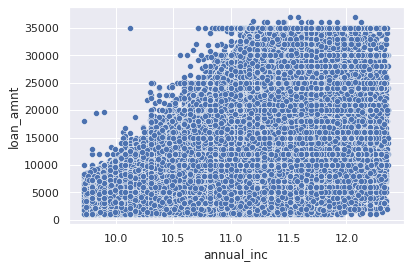

In [80]:
sns.scatterplot(y='loan_amnt',x='annual_inc',data=data)
plt.show()

<b>We can se some positive trend that as annual_inc increases the loan amount taken also rise</b>

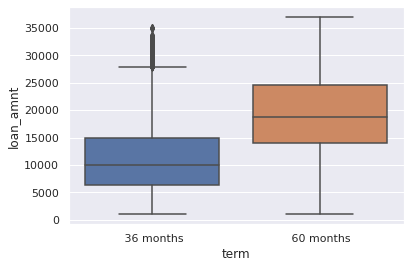

In [81]:
sns.boxplot(x='term',y='loan_amnt',data=data)
plt.show()

<b>Loan amount taken is significantly higher in 60month than for 36 month term.</b>

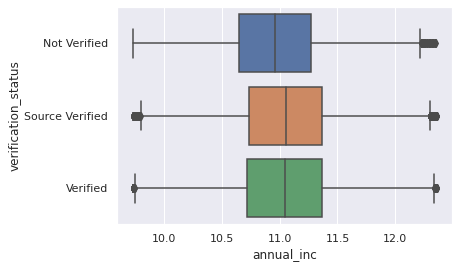

In [82]:
sns.boxplot(y='verification_status',x='annual_inc',data=data)
plt.show()

<b>Almost all verification status have same annual income.</b>

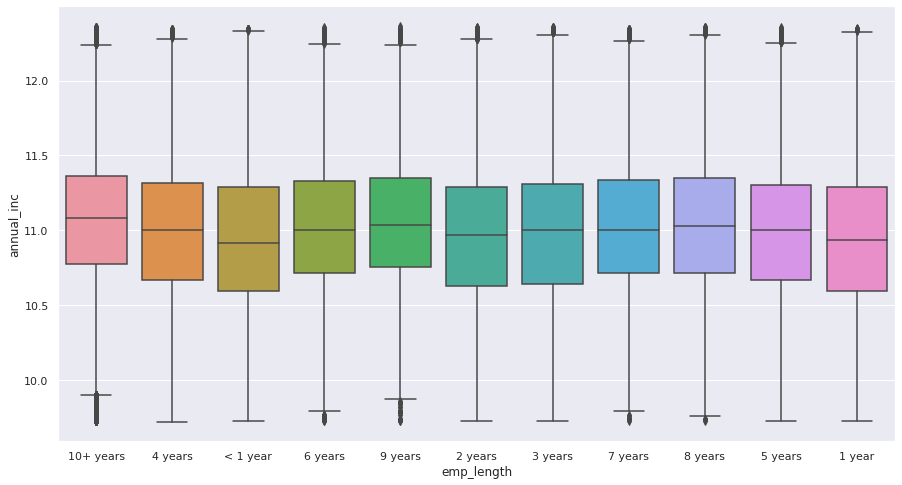

In [83]:
plt.figure(figsize=(15,8))
sns.boxplot(x='emp_length',y='annual_inc',data=data)
plt.show()

<b>Annual income is more or the same over all emp length.</b>

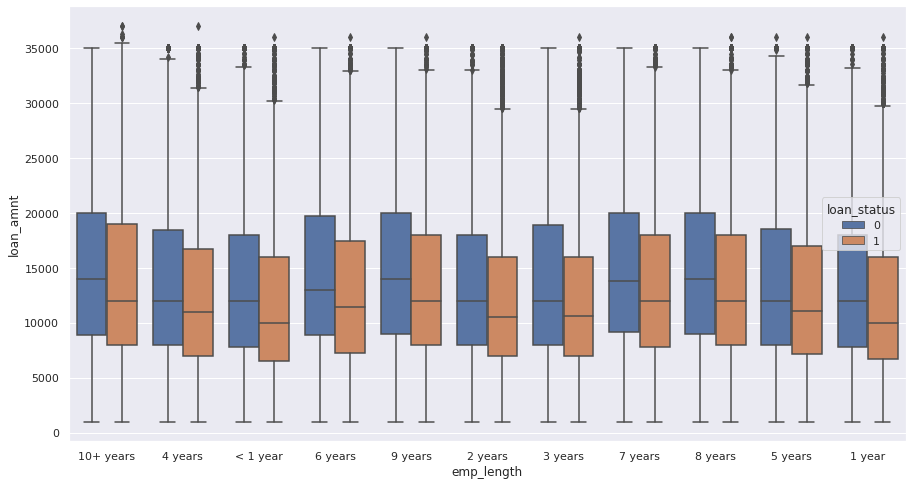

In [84]:
plt.figure(figsize=(15,8))
sns.boxplot(x='emp_length',y='loan_amnt',hue='loan_status',data=data)
plt.show()

<b>We can see almost for all emp length, the avg loan amount is more for the ones which are charged off.</b>

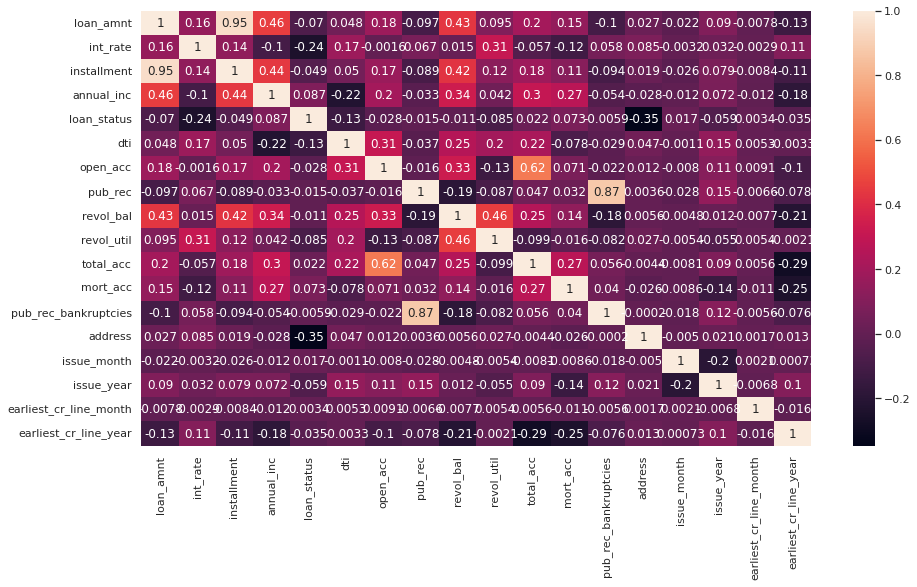

In [85]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(),annot=True)
plt.show()

<hr>

# Data Preparation for model

In [86]:
x = data.drop(columns=['loan_status','issue_month','issue_year','earliest_cr_line_month','earliest_cr_line_year'])
y = pd.DataFrame(data['loan_status'],columns=['loan_status'])

In [87]:
x.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,11.669929,Not Verified,other,26.24,16.0,0,190.706581,41.8,25.0,w,INDIVIDUAL,0,0,22690
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,11.082143,Not Verified,debt_consolidation,22.05,17.0,0,141.883755,53.3,27.0,f,INDIVIDUAL,1,0,5113
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,10.670280,Source Verified,credit_card,12.79,13.0,0,109.485159,92.2,26.0,f,INDIVIDUAL,0,0,5113
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,10.896739,Not Verified,credit_card,2.60,6.0,0,73.972968,21.5,13.0,f,INDIVIDUAL,0,0,813
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,10.915088,Verified,credit_card,33.95,13.0,0,156.792857,69.8,43.0,f,INDIVIDUAL,1,0,11650


In [88]:
y.head()

,loan_status
0,1
1,1
2,1
3,1
4,0


## Encoding Features

In [89]:
le_term = LabelEncoder()
le_grade = LabelEncoder()
le_sub_grade = LabelEncoder()
le_emp_title = LabelEncoder()
le_home_ownership = LabelEncoder()
le_verification_status = LabelEncoder()
le_purpose = LabelEncoder()
le_initial_list_status = LabelEncoder()
le_application_type = LabelEncoder()
x['application_type'] = le_application_type.fit_transform(x['application_type'])
x['initial_list_status'] = le_initial_list_status.fit_transform(x['initial_list_status'])
x['purpose'] = le_purpose.fit_transform(x['purpose'])
x['verification_status'] = le_verification_status.fit_transform(x['verification_status'])
x['home_ownership'] = le_home_ownership.fit_transform(x['home_ownership'])
x['emp_title'] = le_emp_title.fit_transform(x['emp_title'])
x['sub_grade'] = le_sub_grade.fit_transform(x['sub_grade'])
x['grade'] = le_grade.fit_transform(x['grade'])
x['term'] = le_term.fit_transform(x['term'])

In [90]:
x['emp_length'] = x['emp_length'].apply(empLen)

In [91]:
home_ownership_ohe = pd.get_dummies(x['home_ownership'],prefix='home_ownership',prefix_sep='_').drop(columns=['home_ownership_2'])
x = x.merge(home_ownership_ohe,on=x.index)
x.drop(columns=['key_0','home_ownership'],inplace=True)

In [92]:
x.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,verification_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,home_ownership_0,home_ownership_1
0,10000.0,0,11.44,329.48,1,8,73501,10,11.669929,0,2,26.24,16.0,0,190.706581,41.8,25.0,1,1,0,0,22690,0,0
1,8000.0,0,11.99,265.68,1,9,30386,4,11.082143,0,1,22.05,17.0,0,141.883755,53.3,27.0,0,1,1,0,5113,1,0
2,15600.0,0,10.49,506.97,1,7,115256,0,10.670280,1,0,12.79,13.0,0,109.485159,92.2,26.0,0,1,0,0,5113,0,0
3,7200.0,0,6.49,220.65,0,1,25357,6,10.896739,0,0,2.60,6.0,0,73.972968,21.5,13.0,0,1,0,0,813,0,0
4,24375.0,1,17.27,609.33,2,14,34922,9,10.915088,2,0,33.95,13.0,0,156.792857,69.8,43.0,0,1,1,0,11650,1,0


In [93]:
verification_status_ohe = pd.get_dummies(x['verification_status'],prefix='verification_status',prefix_sep='_').drop(columns=['verification_status_2'])
x = x.merge(verification_status_ohe,on=x.index)
x.drop(columns=['key_0','verification_status'],inplace=True)

In [94]:
purpose_ohe = pd.get_dummies(x['purpose'],prefix='purpose',prefix_sep='_').drop(columns=['purpose_2'])
x = x.merge(purpose_ohe,on=x.index)
x.drop(columns=['key_0','purpose'],inplace=True)

<hr>

# Logistic Regression 

### Pre Assumptions - 
There are less pre-assumptions as compared to Linear regression, mainly - 

- No multi-colinearity
- Outliers needs to be removed
- Scaling of data

<b>As we have already removed outliers now we can work on the other assumptions.</b>

In [95]:
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

In [96]:
x_train,x_val,y_train,y_val = train_test_split(x_tr,y_tr,test_size=0.25,random_state=1)

## Scaling Data

In [97]:
ss = StandardScaler()
cols = ['loan_amnt','int_rate','grade','sub_grade','emp_title','emp_length','annual_inc','dti','open_acc','revol_bal','revol_util','total_acc','address']
x_train[cols] = ss.fit_transform(x_train[cols])
x_val[cols] = ss.transform(x_val[cols])

## Removing Multi-colinearity

In [98]:
new_vif = pd.DataFrame()
new_x_t = x_train
new_vif['features'] = new_x_t.columns
new_vif['vif'] = [variance_inflation_factor(new_x_t.values, i) for i in range(new_x_t.shape[1])]
print(new_vif)

                 features         vif
0               loan_amnt   48.934095
1                    term    8.193311
2                int_rate   21.173589
3             installment  182.318339
4                   grade   20.806980
5               sub_grade   40.948610
6               emp_title    1.020697
7              emp_length    1.087522
8              annual_inc    1.723361
9                     dti    1.445273
10               open_acc    2.037620
11                pub_rec    5.133117
12              revol_bal    2.174071
13             revol_util    1.810272
14              total_acc    1.919717
15    initial_list_status    1.781975
16       application_type  177.860298
17               mort_acc    4.720328
18   pub_rec_bankruptcies    4.902805
19                address    1.011364
20       home_ownership_0    3.532952
21       home_ownership_1    1.274478
22  verification_status_0    2.321645
23  verification_status_1    2.106153
24              purpose_0    2.378729
25          

In [99]:
x_train.drop(columns=['installment','sub_grade','application_type','emp_title','pub_rec','address'],inplace=True)

In [100]:
new_vif = pd.DataFrame()
new_x_t = x_train
new_vif['features'] = new_x_t.columns
new_vif['vif'] = [variance_inflation_factor(new_x_t.values, i) for i in range(new_x_t.shape[1])]
print(new_vif)

                 features        vif
0               loan_amnt   1.922010
1                    term   2.108082
2                int_rate  10.756925
3                   grade  10.629492
4              emp_length   1.070775
5              annual_inc   1.712857
6                     dti   1.440804
7                open_acc   2.035264
8               revol_bal   2.159356
9              revol_util   1.798496
10              total_acc   1.893580
11    initial_list_status   1.686205
12               mort_acc   4.183798
13   pub_rec_bankruptcies   1.216634
14       home_ownership_0   3.435335
15       home_ownership_1   1.230397
16  verification_status_0   1.977109
17  verification_status_1   1.831287
18              purpose_0   1.697753
19              purpose_1   2.735866


## Building model

In [101]:
cols = ['loan_amnt','int_rate','grade','sub_grade','emp_title','emp_length','annual_inc','dti','open_acc','revol_bal','revol_util','total_acc','address']
x_test[cols] = ss.transform(x_test[cols])

In [102]:
x_test.drop(columns=['installment','sub_grade','address','pub_rec','application_type','emp_title'],inplace=True)

In [103]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

In [104]:
confusion_matrix(y_test,y_pred)

array([[  953, 12414],
       [  855, 55294]])

In [105]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.53      0.07      0.13     13367
           1       0.82      0.98      0.89     56149

    accuracy                           0.81     69516
   macro avg       0.67      0.53      0.51     69516
weighted avg       0.76      0.81      0.75     69516



In [106]:
f1_score(y_test,y_pred)

0.8928683885448542

In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.5280338193186818

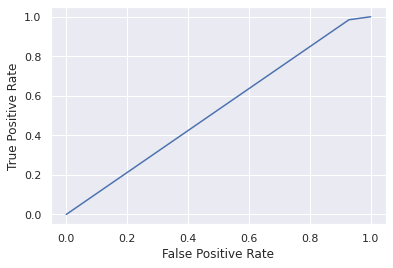

In [108]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [109]:
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))
print("recall_score :", metrics.recall_score(y_test, y_pred))
print("precision_score :", metrics.precision_score(y_test, y_pred))
print("f1_score :" ,metrics.f1_score(y_test, y_pred))
print("AUC score :" ,metrics.roc_auc_score( y_test, y_pred))

Accuracy : 0.809123079578802
recall_score : 0.9847726584623057
precision_score : 0.816653866603651
f1_score : 0.8928683885448542
AUC score : 0.5280338193186818


In [110]:
pd.DataFrame(lr.coef_,columns=x_test.columns)

,loan_amnt,term,int_rate,grade,emp_length,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,home_ownership_0,home_ownership_1,verification_status_0,verification_status_1,purpose_0,purpose_1
0,-0.139754,-0.442056,-0.04345,-0.381017,-0.023932,0.229347,-0.183621,-0.144384,0.105787,-0.141516,0.092941,-0.024147,0.122831,-0.015243,0.175105,0.094468,0.114734,-0.094166,0.156678,0.084614


<hr>

# Questionnaire - 
<b>Question : </b>What percentage of customers have fully paid their Loan Amount?


In [111]:
data['loan_status'].value_counts(normalize=True)*100

1    80.649867
0    19.350133
Name: loan_status, dtype: float64

<b>Answer : 80% of the customers have paid their loan amount.</b>

<b>Question : </b>Comment about the correlation between Loan Amount and Installment features.

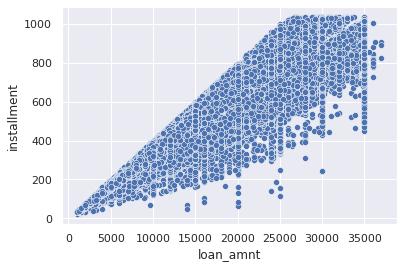

In [112]:
sns.scatterplot(x='loan_amnt',y='installment',data=data)
plt.show()

<b>Answer :</b> We can see an almost linear relationship as the loan amount increases the installement increases.

<b>Question :</b>The majority of people have home ownership as _______.

In [113]:
data['home_ownership'].value_counts()

MORTGAGE    169404
RENT        145626
OTHER        32549
Name: home_ownership, dtype: int64

<b>Answer :</b> Majority of people have home ownership as Mortgage or Rent

<b>Question :</b> People with grades ‘A’ are more likely to fully pay their loan. (T/F)

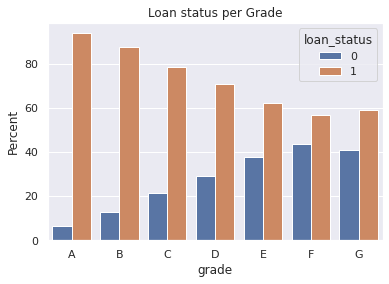

In [114]:
plt.figure()
(data
 .groupby(['grade'])['loan_status']
 .value_counts(normalize=True)
 .mul(100)
 .rename('Percent')
 .reset_index()
 .pipe((sns.barplot,'data'),x = "grade",y="Percent",hue='loan_status')
)
plt.title('Loan status per Grade')
plt.show()

<b>Answer :</b> True

<b>Question :</b> Name the top 2 afforded job titles.

In [115]:
data['emp_title'].value_counts().head()

Teacher             23314
Manager              3674
Supervisor           1628
Registered Nurse     1547
RN                   1527
Name: emp_title, dtype: int64

<b>Answer :</b> Top afforded job titles are Teacher and Manager

<b>Question: </b>Thinking from a bank's perspective, which metric should our primary focus be on?

<ol>
    <li>ROC AUC</li>
    <li>Precision</li>
    <li>Recall</li>
    <li>F1 Score</li>
</ol>

<b>Answer : 4. F1 Score</b> 

<b>Question :</b> How does the gap in precision and recall affect the bank?

<b>Answer :</b> For our models, classifying whether a bank customer is a loan defaulter or not, it is desirable to have a high precision since the bank wouldn’t want to lose customers who were denied a loan based on the model’s prediction that they would be defaulters. 

<b>Question :</b> Which were the features that heavily affected the outcome?

<b>Answer :</b> For our models, classifying whether a bank customer is a loan defaulter or not, it is desirable to have a high precision since the bank wouldn’t want to lose customers who were denied a loan based on the model’s prediction that they would be defaulters. 

<b>Question :</b> Which were the features that heavily affected the outcome?

In [116]:
effect = pd.DataFrame((lr.coef_[0]).reshape(len(lr.coef_[0]),1),index=x_test.columns)
effect

,0
loan_amnt,-0.139754
term,-0.442056
int_rate,-0.043450
grade,-0.381017
emp_length,-0.023932
annual_inc,0.229347
dti,-0.183621
open_acc,-0.144384
revol_bal,0.105787
revol_util,-0.141516


<b>Answer :</b> We can see the factors like Purpose, term and grade effect the model the most

<b>Question :</b> Will the results be affected by geographical location? (Yes/No)

In [117]:
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,random_state=1)
x_train,x_val,y_train,y_val = train_test_split(x_tr,y_tr,test_size=0.25,random_state=1)
cols = ['loan_amnt','int_rate','grade','sub_grade','emp_title','emp_length','annual_inc','dti','open_acc','revol_bal','revol_util','total_acc','address']
x_train[cols] = ss.fit_transform(x_train[cols])
x_val[cols] = ss.transform(x_val[cols])
x_train.drop(columns=['installment','sub_grade','pub_rec','application_type','emp_title'],inplace=True)
x_test[cols] = ss.transform(x_test[cols])
x_test.drop(columns=['installment','sub_grade','pub_rec','application_type','emp_title'],inplace=True)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))
print("recall_score :", metrics.recall_score(y_test, y_pred))
print("precision_score :", metrics.precision_score(y_test, y_pred))
print("f1_score :" ,metrics.f1_score(y_test, y_pred))
print("AUC score :" ,metrics.roc_auc_score( y_test, y_pred))

Accuracy : 0.8408423959951665
recall_score : 0.9684767315535451
precision_score : 0.854035462440909
f1_score : 0.9076630334996912
AUC score : 0.6365911749336515


<b>Answer :</b> We can clearly see the accuracy, F1 and AUC score getting better on the addition of geographical location.

<b>Question :</b> How does Over-sampling affect the model’s performance?

In [118]:
sm = SMOTE()
x,y = sm.fit_resample(x,y)

In [119]:
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,random_state=1)
x_train,x_val,y_train,y_val = train_test_split(x_tr,y_tr,test_size=0.25,random_state=1)
cols = ['loan_amnt','int_rate','grade','sub_grade','emp_title','emp_length','annual_inc','dti','open_acc','revol_bal','revol_util','total_acc','address']
x_train[cols] = ss.fit_transform(x_train[cols])
x_val[cols] = ss.transform(x_val[cols])
x_train.drop(columns=['installment','int_rate','sub_grade','pub_rec','application_type','emp_title'],inplace=True)
x_test[cols] = ss.transform(x_test[cols])
x_test.drop(columns=['installment','int_rate','sub_grade','pub_rec','application_type','emp_title'],inplace=True)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))
print("recall_score :", metrics.recall_score(y_test, y_pred))
print("precision_score :", metrics.precision_score(y_test, y_pred))
print("f1_score :" ,metrics.f1_score(y_test, y_pred))
print("AUC score :" ,metrics.roc_auc_score( y_test, y_pred))

Accuracy : 0.7928724950726396
recall_score : 0.7987578081899237
precision_score : 0.7901936619718309
f1_score : 0.7944526555212362
AUC score : 0.7928591858354603


<b>Answer :</b> We can see that the Accuracy and F1 getting lower. But on the other hand AUC score is pretty good in this model.

<hr>

# Recommendations - 

1. Using high precision we can say if a person will pay the loan back or not. 

2. As seen in the graphs loan taken under grade A,B and C have a high chance of paying back compared to other grades. So we can trust a customer with loan grades A, B and C.

3. We can clearly say that the loan amount taken is significantly higher for 60months tenure so we can say I a loan amount taken is high and term is 36 months, we can choose other factors as income to disburse the loan, as people wit high income will be able to to pay the amount in less term duration.